# Crown-of-Thorns Starfish (COTS) Detection using EfficientDet

### Install TensorFlow Object Detection API

In [1]:
!git clone https://github.com/tensorflow/models
    
# Check out a certain commit to ensure that future changes in the TF ODT API codebase won't affect this notebook.
!cd models && git checkout ac8d06519

Cloning into 'models'...
remote: Enumerating objects: 67341, done.
remote: Total 67341 (delta 0), reused 0 (delta 0), pack-reused 67341
Receiving objects: 100% (67341/67341), 576.18 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (47261/47261), done.
Note: checking out 'ac8d06519'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ac8d06519 Add SpaghettiNet Feature Extractor


In [2]:
%%bash
cd models/research

# Compile protos.
protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
wget https://storage.googleapis.com/odml-dataset/others/setup.py
pip install -q --user .

# Test if the Object Dectection API is working correctly
python object_detection/builders/model_builder_tf2_test.py

--2021-11-22 09:23:09--  https://storage.googleapis.com/odml-dataset/others/setup.py
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 173.194.216.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1401 (1.4K) [text/x-python]
Saving to: ‘setup.py’

     0K .                                                     100% 11.6M=0s

2021-11-22 09:23:10 (11.6 MB/s) - ‘setup.py’ saved [1401/1401]

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Consider adding this directory to PATH or, if you prefer 

### Import Libraries

In [3]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time

from PIL import Image, ImageDraw

# Import the library to submit the prediction result.
INPUT_DIR = '/kaggle/input/tensorflow-great-barrier-reef/'
sys.path.insert(0, INPUT_DIR)
import greatbarrierreef

In [4]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.6.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-11-22 09:24:51.388772: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 09:24:51.421316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 09:24:51.432614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 09:24:51.433688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Prepare the training dataset

Split the `train` folder into training dataset and validation dataset. 

In [5]:
TRAINING_RATIO = 0.8

data_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# Split the dataset so that no sequence is leaked from the training dataset into the validation dataset.
split_index = int(TRAINING_RATIO * len(data_df))
while data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    split_index += 1

# Shuffle both the training and validation datasets.
train_data_df = data_df.iloc[:split_index].sample(frac=1).reset_index(drop=True)
val_data_df = data_df.iloc[split_index:].sample(frac=1).reset_index(drop=True)

train_positive_count = len(train_data_df[train_data_df.annotations != '[]'])
val_positive_count = len(val_data_df[val_data_df.annotations != '[]'])

print('Training ratio (all samples):', 
      float(len(train_data_df)) / (len(train_data_df) + len(val_data_df)))
print('Training ratio (positive samples):', 
      float(train_positive_count) / (train_positive_count + val_positive_count))

Training ratio (all samples): 0.8197523509637887
Training ratio (positive samples): 0.868265907704818


In [6]:
# Take only the positive images for training and validation
train_data_df = train_data_df[train_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_data_df))
val_data_df = val_data_df[val_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for validation:', len(val_data_df))

Number of positive images used for training: 4271
Number of positive images used for validation: 648


Visualize one randomly selected image from the training data to see if the annotation looks correct.

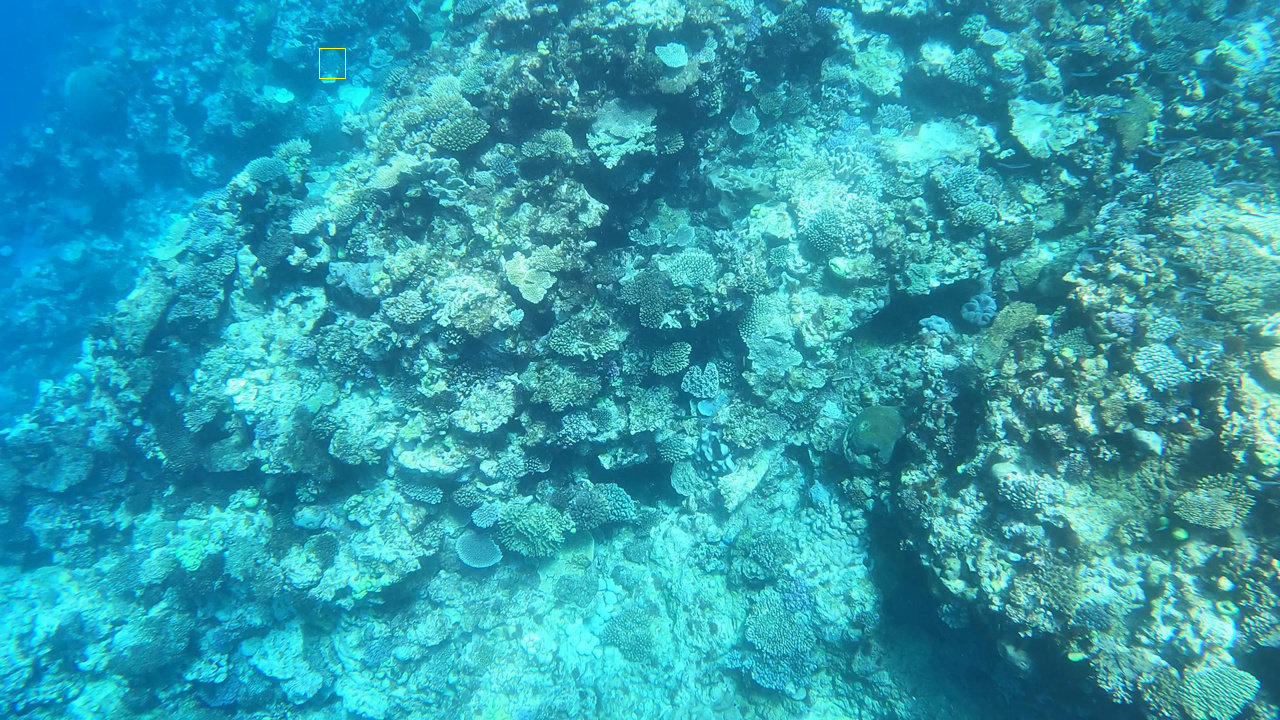

In [7]:
def image_with_annotation(video_id, video_frame, data_df, image_path):
    """Visualize annotations of a given image."""
    full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
    image = Image.open(full_path)
    draw = ImageDraw.Draw(image)

    rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
    for _, row in rows.iterrows():
        annotations = json.loads(row.annotations.replace("'", '"'))
        for annotation in annotations:
            draw.rectangle((
                annotation['x'], 
                annotation['y'],
                (annotation['x'] + annotation['width']), 
                (annotation['y'] + annotation['height']),
                ), outline=(255, 255, 0))
        
    buf = io.BytesIO()
    image.save(buf, 'PNG')
    data = buf.getvalue()

    return data

# Test visualization of a randomly selected image
image_path = os.path.join(INPUT_DIR, 'train_images')
test_index = 38
video_id = train_data_df.iloc[test_index].video_id
video_frame = train_data_df.iloc[test_index].video_frame
IPython.display.Image(image_with_annotation(video_id, video_frame, data_df, image_path))

Convert the training and validation dataset into TFRecord format (required by the TensorFlow Object Detection API).

In [8]:
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util


def create_tf_example(video_id, video_frame, data_df, image_path):
    """Create a tf.Example entry for a given training image."""
    full_path = os.path.join(image_path, os.path.join(f'video_{video_id}', f'{video_frame}.jpg'))
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')

    height = image.size[1] # Image height
    width = image.size[0] # Image width
    filename = f'{video_id}:{video_frame}'.encode('utf8') # Unique id of the image.
    encoded_image_data = None # Encoded image bytes
    image_format = 'jpeg'.encode('utf8') # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)

    rows = data_df[(data_df.video_id == video_id) & (data_df.video_frame == video_frame)]
    for _, row in rows.iterrows():
        annotations = json.loads(row.annotations.replace("'", '"'))
        for annotation in annotations:
            xmins.append(annotation['x'] / width) 
            xmaxs.append((annotation['x'] + annotation['width']) / width) 
            ymins.append(annotation['y'] / height) 
            ymaxs.append((annotation['y'] + annotation['height']) / height) 

            classes_text.append('COTS'.encode('utf8'))
            classes.append(1)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example

def convert_to_tfrecord(data_df, tfrecord_filebase, image_path, num_shards = 10):
    """Convert the object detection dataset to TFRecord as required by the TF ODT API."""
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
            tf_record_close_stack, tfrecord_filebase, num_shards)
        
        for index, row in data_df.iterrows():
            if index % 500 == 0:
                print('Processed {0} images.'.format(index))
            tf_example = create_tf_example(row.video_id, row.video_frame, data_df, image_path)
            output_shard_index = index % num_shards
            output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
        
        print('Completed processing {0} images.'.format(len(data_df)))

!mkdir dataset
image_path = os.path.join(INPUT_DIR, 'train_images')

# Convert train images to TFRecord
print('Converting TRAIN images...')
convert_to_tfrecord(
  train_data_df,
  'dataset/cots_train',
  image_path,
  num_shards = 4
)

# Convert validation images to TFRecord
print('Converting VALIDATION images...')
convert_to_tfrecord(
  val_data_df,
  'dataset/cots_val',
  image_path,
  num_shards = 4
)

Converting TRAIN images...
Processed 0 images.
Processed 500 images.
Processed 1000 images.
Processed 1500 images.
Processed 2000 images.
Processed 2500 images.
Processed 3000 images.
Processed 3500 images.
Processed 4000 images.
Completed processing 4271 images.
Converting VALIDATION images...
Processed 0 images.
Processed 500 images.
Completed processing 648 images.


In [9]:
# Create a label map to map between label index and human-readable label name.

label_map_str = """item {
  id: 1
  name: 'COTS'
}"""

with open('dataset/label_map.pbtxt', 'w') as f:
  f.write(label_map_str)

!more dataset/label_map.pbtxt

item {
  id: 1
  name: 'COTS'
}


### Train an object detection model

Used the [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) and an EfficientDet-D0 base model with Transfer Learning to train an object detection model.

In [10]:
# Download the pretrained EfficientDet-D0 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz

--2021-11-22 09:26:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.215.128, 2607:f8b0:400c:c0c::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.215.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  39.6MB/s    in 0.7s    

2021-11-22 09:26:34 (39.6 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientde

In [11]:
from string import Template

config_file_template = """
# SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Initialized from an EfficientDet-D0 checkpoint.
#
# Train on GPU

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: [1.0, 2.0, 0.5]
        scales_per_octave: 3
      }
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 1280
        max_dimension: 1280
        pad_to_max_dimension: true
        }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        depth: 64
        class_prediction_bias_init: -4.6
        conv_hyperparams {
          force_use_bias: true
          activation: SWISH
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            random_normal_initializer {
              stddev: 0.01
              mean: 0.0
            }
          }
          batch_norm {
            scale: true
            decay: 0.99
            epsilon: 0.001
          }
        }
        num_layers_before_predictor: 3
        kernel_size: 3
        use_depthwise: true
      }
    }
    feature_extractor {
      type: 'ssd_efficientnet-b0_bifpn_keras'
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
      conv_hyperparams {
        force_use_bias: true
        activation: SWISH
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          scale: true,
          decay: 0.99,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid_focal {
          alpha: 0.25
          gamma: 1.5
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    normalize_loc_loss_by_codesize: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  fine_tune_checkpoint: "efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint_type: "detection"
  batch_size: 2
  sync_replicas: false
  startup_delay_steps: 0
  replicas_to_aggregate: 1
  use_bfloat16: false
  num_steps: $training_steps
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 1280
      scale_min: 0.5
      scale_max: 2.0
    }
  }
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: 5e-3
          total_steps: $training_steps
          warmup_learning_rate: 5e-4
          warmup_steps: $warmup_steps
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}

train_input_reader: {
  label_map_path: "dataset/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "dataset/cots_train-?????-of-00004"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 2;
}

eval_input_reader: {
  label_map_path: "dataset/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "dataset/cots_val-?????-of-00004"
  }
}
"""

In [12]:
# Define the training pipeline

TRAINING_STEPS = 20000
WARMUP_STEPS = 2000
PIPELINE_CONFIG_PATH='dataset/pipeline.config'

pipeline = Template(config_file_template).substitute(
    training_steps=TRAINING_STEPS, warmup_steps=WARMUP_STEPS)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

In [13]:
MODEL_DIR='cots_efficientdet_d0'
!mkdir {MODEL_DIR}
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr

2021-11-22 09:26:42.965285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 09:26:43.002470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 09:26:43.003668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 09:26:43.007621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Evaluate the Model

In [14]:
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={MODEL_DIR} \
    --eval_timeout=0 \
    --alsologtostderr

2021-11-22 14:52:54.870805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 14:52:54.936824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 14:52:54.937963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W1122 14:52:54.948140 139631711037248 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
I1122 14:52:54.948447 139631711037248 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
I1122 14:52:54.948590 139631711037248 config_util.py:552] Maybe overwriting use_bfloat16: False
I1122 14:52:54.9

### Export Model as SavedModel for inference

In [15]:
!python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir={MODEL_DIR} \
    --output_directory={MODEL_DIR}/output

2021-11-22 14:58:18.440609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 14:58:18.451781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 14:58:18.452781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 14:58:18.463564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
!ls {MODEL_DIR}/output

checkpoint  pipeline.config  saved_model


### Run inference on test images

In [17]:
# Load the TensorFlow COTS detection model into memory.
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn_tf_odt = tf.saved_model.load(os.path.join(os.path.join(MODEL_DIR, 'output'), 'saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

2021-11-22 15:00:55.521149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 15:00:55.522372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 15:00:55.523407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 15:00:55.524623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 15:00:55.525627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Elapsed time: 36.305323362350464s


In [18]:
# Define some utils method for prediction.

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path (this can be local or on colossus)

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(io.BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def detect(image_np):
    """Detect COTS from a given numpy image."""

    input_tensor = np.expand_dims(image_np, 0)
    start_time = time.time()
    detections = detect_fn_tf_odt(input_tensor)
    return detections

In [19]:
import greatbarrierreef
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

In [20]:
DETECTION_THRESHOLD = 0.3

submission_dict = {
    'id': [],
    'prediction_string': [],
}

for (image_np, sample_prediction_df) in iter_test:
    height, width, _ = image_np.shape
    
    # Run object detection using the TensorFlow model.
    detections = detect(image_np)
    
    # Parse the detection result and generate a prediction string.
    num_detections = detections['num_detections'][0].numpy().astype(np.int32)
    predictions = []
    for index in range(num_detections):
        score = detections['detection_scores'][0][index].numpy()
        if score < DETECTION_THRESHOLD:
            continue

        bbox = detections['detection_boxes'][0][index].numpy()
        y_min = int(bbox[0] * height)
        x_min = int(bbox[1] * width)
        y_max = int(bbox[2] * height)
        x_max = int(bbox[3] * width)
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    
    # Generate the submission data.
    prediction_str = ' '.join(predictions)
    sample_prediction_df['annotations'] = prediction_str
    env.predict(sample_prediction_df)

    print('Prediction:', prediction_str)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


2021-11-22 15:01:32.235027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-22 15:01:34.602764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Prediction: 
Prediction: 
Prediction: 
